In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/xai-data/clinical_mastitis_cows.csv


In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import shap

2024-06-23 16:39:43.423114: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 16:39:43.423328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 16:39:43.599015: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load the dataset
file_path = "/kaggle/input/xai-data/clinical_mastitis_cows.csv"  # Update with the correct path
df = pd.read_csv(file_path)

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Load dataset (assuming dataset is already loaded and boolean columns converted)

df = df.drop(columns=[ 'Day','Cow_ID','Milk_visibility'])
df = pd.get_dummies(df)

df

,Months after giving birth,Previous_Mastits_status,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature,Hardness,Pain,class1,Breed_Jersey,Breed_hostlene
0,1,0,150,180,150,180,150,181,150,181,43,0,0,0,True,False
1,1,0,152,180,152,185,151,180,152,181,42,0,0,0,True,False
2,1,0,152,182,153,186,151,186,153,183,41,0,0,0,True,False
3,1,0,155,183,155,189,155,182,155,186,40,0,0,0,True,False
4,1,0,150,186,150,181,150,185,150,188,41,0,0,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,5,0,243,285,310,361,241,285,246,281,43,1,0,1,True,False
6596,5,0,240,276,315,358,242,285,247,284,43,1,0,1,True,False
6597,5,0,242,286,315,365,237,279,248,288,43,1,0,1,True,False
6598,5,0,245,285,314,361,239,280,241,288,43,1,0,1,True,False


In [5]:
df['Breed_Jersey'] = df['Breed_Jersey'].apply(lambda x: 1 if x else 0)
df['Breed_hostlene'] = df['Breed_hostlene'].apply(lambda x: 1 if x else 0)


y = df['class1'].values


x = df.drop('class1', axis=1)
x.info()
x

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6600 entries, 0 to 6599
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Months after giving birth  6600 non-null   int64
 1   Previous_Mastits_status    6600 non-null   int64
 2   IUFL                       6600 non-null   int64
 3   EUFL                       6600 non-null   int64
 4   IUFR                       6600 non-null   int64
 5   EUFR                       6600 non-null   int64
 6   IURL                       6600 non-null   int64
 7   EURL                       6600 non-null   int64
 8   IURR                       6600 non-null   int64
 9   EURR                       6600 non-null   int64
 10  Temperature                6600 non-null   int64
 11  Hardness                   6600 non-null   int64
 12  Pain                       6600 non-null   int64
 13  Breed_Jersey               6600 non-null   int64
 14  Breed_hostlene          

,Months after giving birth,Previous_Mastits_status,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature,Hardness,Pain,Breed_Jersey,Breed_hostlene
0,1,0,150,180,150,180,150,181,150,181,43,0,0,1,0
1,1,0,152,180,152,185,151,180,152,181,42,0,0,1,0
2,1,0,152,182,153,186,151,186,153,183,41,0,0,1,0
3,1,0,155,183,155,189,155,182,155,186,40,0,0,1,0
4,1,0,150,186,150,181,150,185,150,188,41,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,5,0,243,285,310,361,241,285,246,281,43,1,0,1,0
6596,5,0,240,276,315,358,242,285,247,284,43,1,0,1,0
6597,5,0,242,286,315,365,237,279,248,288,43,1,0,1,0
6598,5,0,245,285,314,361,239,280,241,288,43,1,0,1,0


col:  Months after giving birth


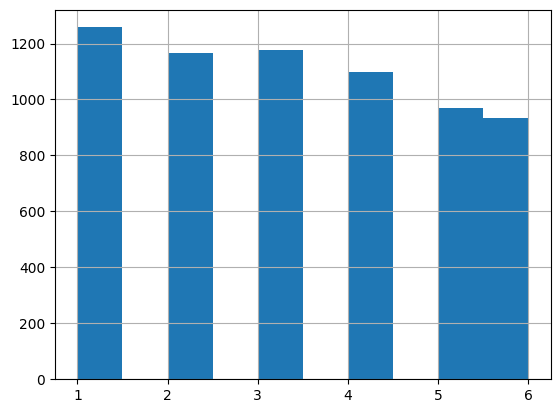

col:  Previous_Mastits_status


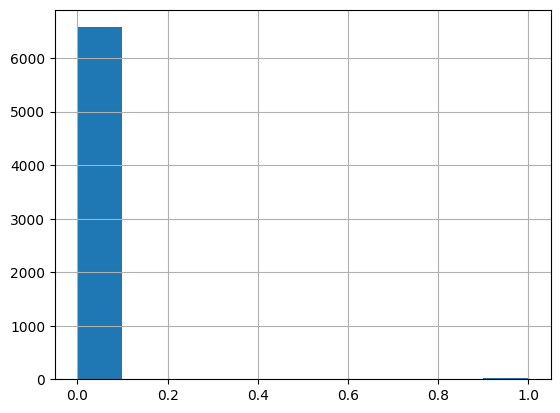

col:  IUFL


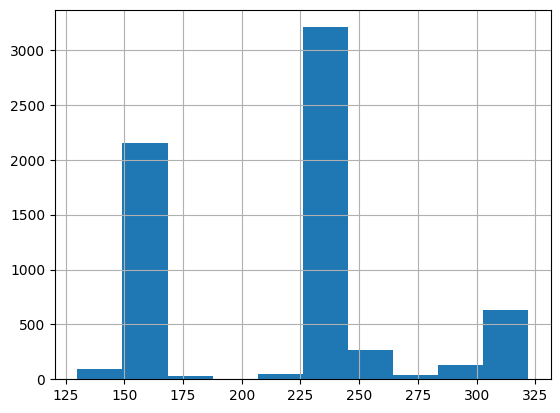

col:  EUFL


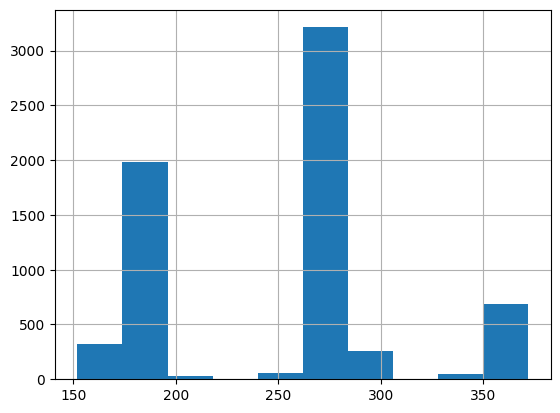

col:  IUFR


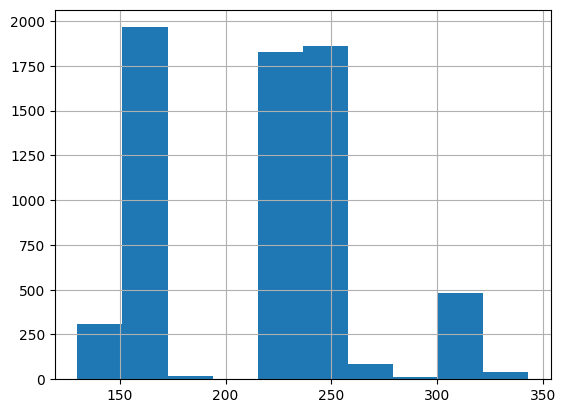

col:  EUFR


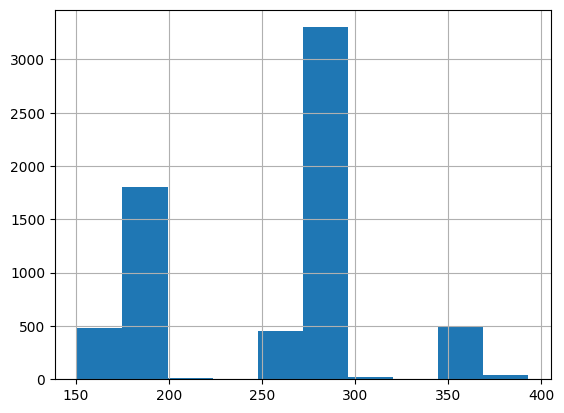

col:  IURL


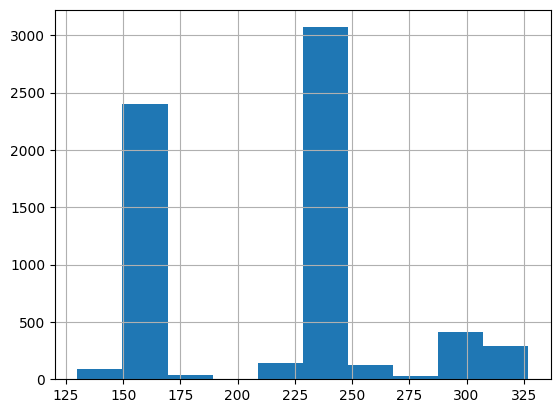

col:  EURL


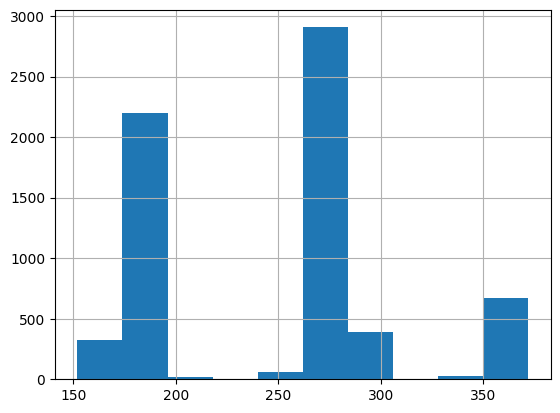

col:  IURR


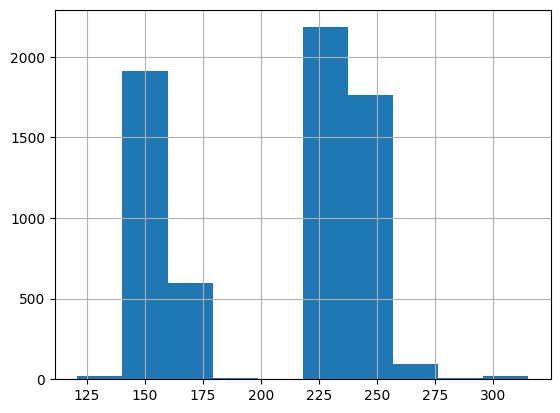

col:  EURR


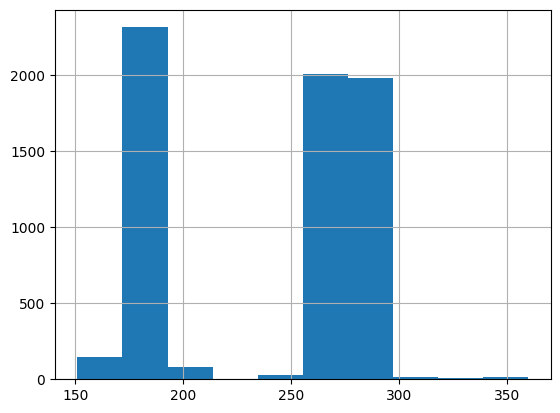

col:  Temperature


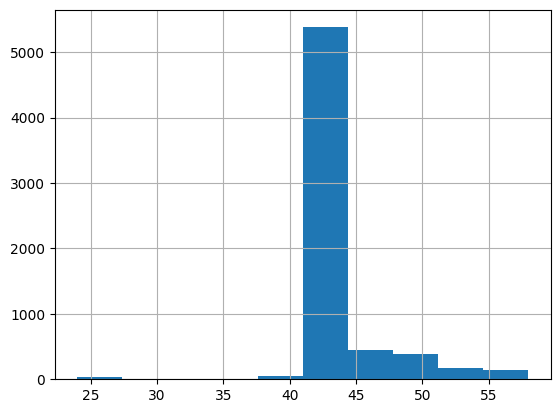

col:  Hardness


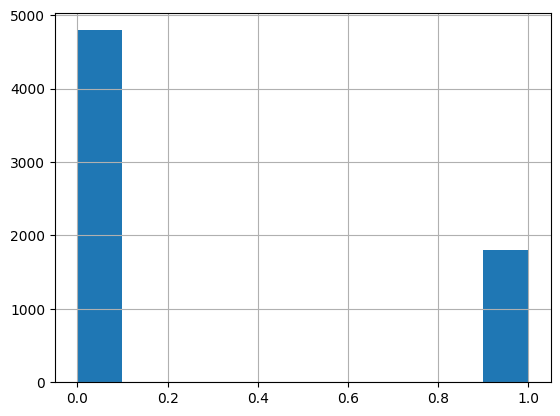

col:  Pain


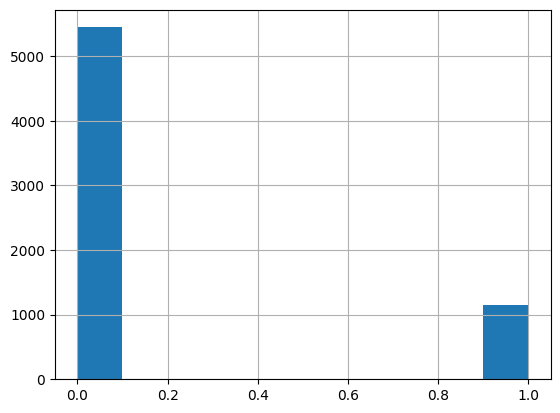

col:  class1


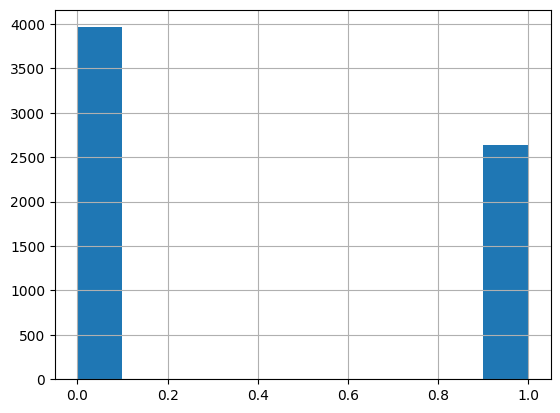

col:  Breed_Jersey


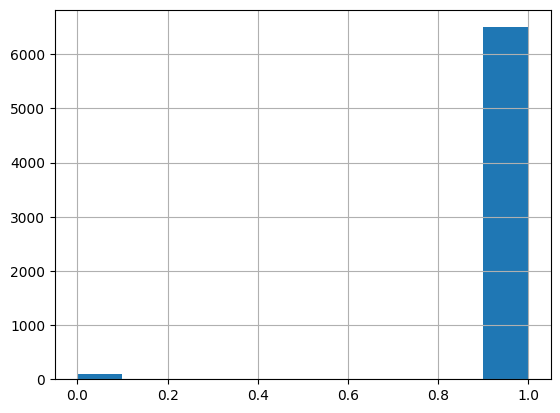

col:  Breed_hostlene


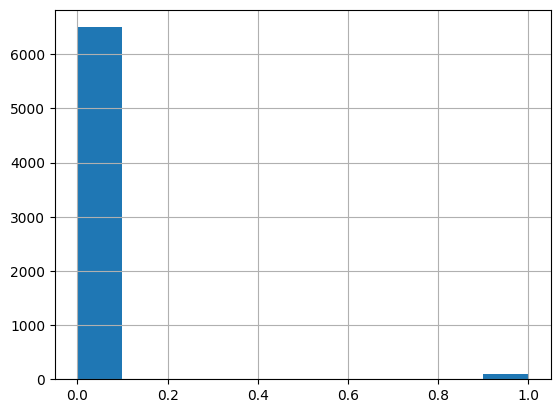

In [6]:
import matplotlib.pyplot as plt

columns = df.columns
for col in columns:
    print("col: ", col)
    df[col].hist()
    plt.show()

In [7]:
# Split data into training, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

print("Training set size:", X_train.shape[0], "or", round(X_train.shape[0]/x.shape[0]*100, 1), "%")
print("Test set size:", X_test.shape[0], "or", round(X_test.shape[0]/x.shape[0]*100, 1), "%")
print("Validation set size:", X_val.shape[0], "or", round(X_val.shape[0]/x.shape[0]*100, 1), "%")

Training set size: 4620 or 70.0 %
Test set size: 1326 or 20.1 %
Validation set size: 654 or 9.9 %


In [8]:
# Reshape the input data for LSTM (samples, time steps, features)
n_features = X_train.shape[1]
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, n_features))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, n_features))
X_val_reshaped = X_val.values.reshape((X_val.shape[0], 1, n_features))

X_val_reshaped

array([[[  5,   0, 160, ...,   0,   1,   0]],

       [[  1,   0, 243, ...,   0,   1,   0]],

       [[  3,   0, 160, ...,   0,   1,   0]],

       ...,

       [[  3,   0, 164, ...,   0,   1,   0]],

       [[  3,   0, 232, ...,   0,   1,   0]],

       [[  4,   0, 231, ...,   0,   1,   0]]])

In [9]:
# Define and compile the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, n_features)),
    LSTM(50),
    Dense(1, activation='sigmoid')
])


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=50, validation_data=(X_val_reshaped, y_val))

Epoch 1/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7793 - loss: 0.5452 - val_accuracy: 0.8991 - val_loss: 0.3215
Epoch 2/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8992 - loss: 0.3134 - val_accuracy: 0.9006 - val_loss: 0.3168
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9001 - loss: 0.3006 - val_accuracy: 0.8930 - val_loss: 0.3200
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9029 - loss: 0.2999 - val_accuracy: 0.8945 - val_loss: 0.2979
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9039 - loss: 0.2787 - val_accuracy: 0.8991 - val_loss: 0.3320
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8962 - loss: 0.3063 - val_accuracy: 0.8991 - val_loss: 0.3007
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9059 - loss: 0.2727 - val_accuracy: 0.8960 - val_loss: 0.2978
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9032 - loss: 0.2779 - val_accuracy: 0.

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 50)          │        13,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,355 (392.02 KB)

 Trainable params: 33,451 (130.67 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 66,904 (261.35 KB)

In [13]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print("Test Accuracy:", test_acc)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9038 - loss: 0.2951
Test Accuracy: 0.9193061590194702


In [14]:
# Making predictions
predictions = model.predict(X_test_reshaped)
binary_predictions = (predictions > 0.5).astype(int)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [15]:
import pandas as pd

# Assuming 'predictions' are in the format returned by model.predict() and are probabilities
# Flatten the predictions array and round them off for better readability
predicted_probs = predictions.flatten().round(2)

# Create a DataFrame from the test set features
test_features = pd.DataFrame(X_test_reshaped.reshape(X_test_reshaped.shape[0], n_features), columns=X_test.columns)

# Add the predictions and the actual labels to the DataFrame
test_features['Predicted Probability'] = predicted_probs
test_features['Actual Label'] = y_test  # Assuming y_test is accessible

# Sort the DataFrame by 'Predicted Probability' to get the top predictions
test_features_sorted = test_features.sort_values(by='Predicted Probability', ascending=False)

In [16]:
# Display the top 5 predictions
top_5_predictions = test_features_sorted.head(5)
print(top_5_predictions)

      Months after giving birth  Previous_Mastits_status  IUFL  EUFL  IUFR  \
828                           1                        0   314   355   161   
199                           1                        0   307   358   159   
921                           3                        0   312   372   158   
180                           3                        0   156   180   304   
1222                          2                        0   312   362   151   

      EUFR  IURL  EURL  IURR  EURR  Temperature  Hardness  Pain  Breed_Jersey  \
828    178   157   174   160   183           47         1     1             1   
199    183   157   186   152   191           44         1     1             1   
921    191   159   182   160   182           52         1     1             1   
180    360   154   174   160   177           45         1     1             1   
1222   181   151   182   152   181           52         1     1             1   

      Breed_hostlene  Predicted Probability 

In [17]:
 top_5_predictions.to_csv("top_5_predictions_v1.0.csv", index=False)
top_5_predictions.info

<bound method DataFrame.info of       Months after giving birth  Previous_Mastits_status  IUFL  EUFL  IUFR  \
828                           1                        0   314   355   161   
199                           1                        0   307   358   159   
921                           3                        0   312   372   158   
180                           3                        0   156   180   304   
1222                          2                        0   312   362   151   

      EUFR  IURL  EURL  IURR  EURR  Temperature  Hardness  Pain  Breed_Jersey  \
828    178   157   174   160   183           47         1     1             1   
199    183   157   186   152   191           44         1     1             1   
921    191   159   182   160   182           52         1     1             1   
180    360   154   174   160   177           45         1     1             1   
1222   181   151   182   152   181           52         1     1             1   

      Breed_

In [18]:
# Convert probabilities to binary predictions
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

In [19]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

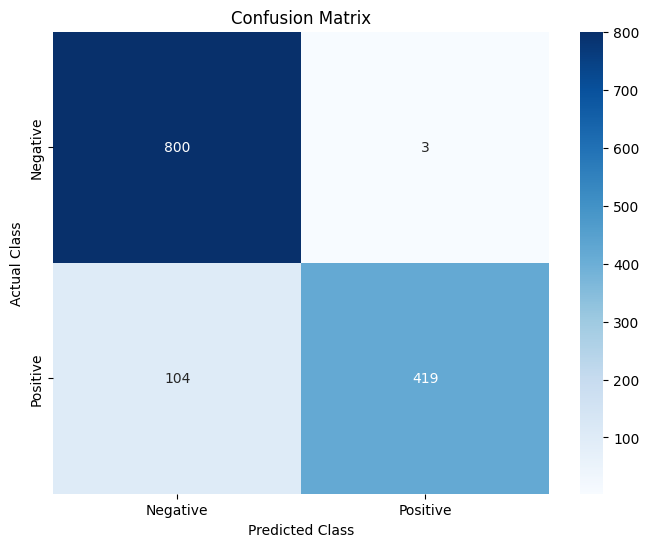

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the labels for the confusion matrix (adjust labels for your specific case)
labels = ['Negative', 'Positive']

# Create a heatmap from the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9193061840120663
Precision: 0.9928909952606635
Recall: 0.8011472275334608
F1 Score: 0.8867724867724868


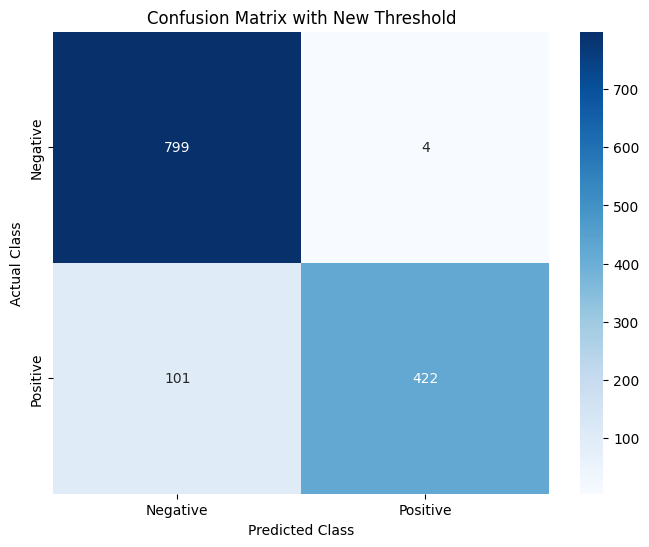

In [22]:
# Example: Adjusting threshold to prioritize recall
new_threshold = 0.4
new_binary_predictions = (predictions > new_threshold).astype(int)
new_conf_matrix = confusion_matrix(y_test, new_binary_predictions)

# Redisplay new confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(new_conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix with New Threshold')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

True Negatives (TN): 800
False Positives (FP): 3
False Negatives (FN): 104
True Positives (TP): 419


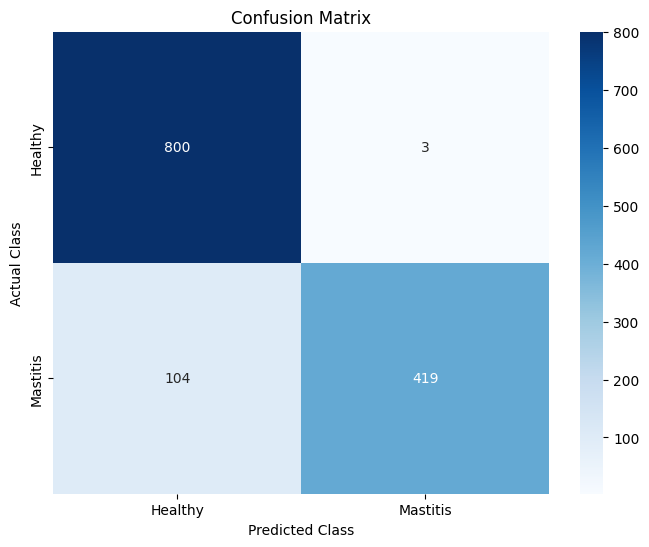

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming binary_predictions and y_test are already defined

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Extract TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix.ravel()

# Print TN, FP, FN, TP
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")

# Optional: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Healthy', 'Mastitis'], yticklabels=['Healthy', 'Mastitis'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


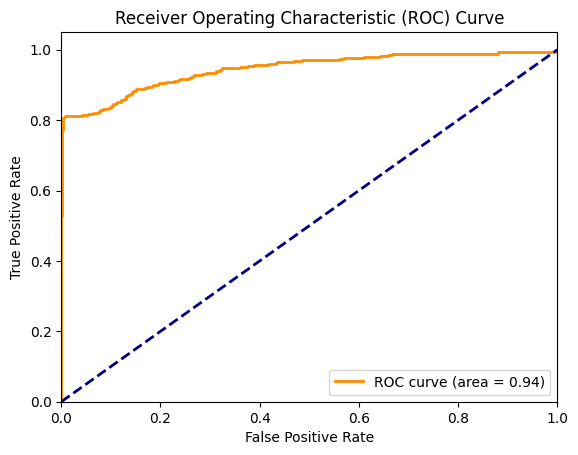

In [24]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_pred_prob = model.predict(X_test_reshaped).ravel()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [25]:
print(model.output_shape)

(None, 1)


In [26]:
# Making predictions
predictions = model.predict(X_test_reshaped)
binary_predictions = (predictions > 0.5).astype(int)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [27]:
X_train_flat = X_train.values
X_test_flat = X_test.values

In [28]:
def model_predict(data):
    reshaped_data = data.reshape(data.shape[0], 1, data.shape[1])
    return model.predict(reshaped_data)

In [29]:
# Initialize KernelExplainer with a sample of the training data
explainer = shap.KernelExplainer(model_predict, shap.sample(X_train_flat, 100))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [30]:
shap_values = explainer.shap_values(X_test_flat[:20], nsamples=100)

  0%|          | 0/20 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━

In [31]:
# Ensure that single_record_features is correctly shaped
single_record_features = X_test_flat[0]  # This assumes X_test_flat is (samples, features) and already 2D

# Check the shape or length
print("Features length:", len(single_record_features))

# Select SHAP values for a single record, assuming shap_values is a 2D array of shape (100, 16)
single_record_shap_values = shap_values[0]
print("Correctly selected SHAP values length:", len(single_record_shap_values))

Features length: 15
Correctly selected SHAP values length: 20


In [32]:
explainer.expected_value

array([0.38608965])

In [33]:
single_record_features = X_test_flat[0]  # This should be a flat array with the same length as SHAP values
print("Features shape:", single_record_features.shape)

print("SHAP values:", single_record_shap_values)
print("Feature values:", single_record_features)


Features shape: (15,)
SHAP values: [[ 0.          0.          0.         -0.09439103 -0.01639927  0.04379129
  -0.06286214  0.07135005 -0.06134512 -0.11670691  0.         -0.09073133
   0.          0.          0.        ]
 [ 0.02988964  0.          0.01668235 -0.02291224 -0.15301873  0.58987634
   0.01416581  0.05818553  0.         -0.05350726  0.02708421  0.1404954
  -0.04567117  0.          0.        ]
 [ 0.          0.         -0.16619353 -0.04341895  0.206343   -0.32558709
   0.19523289 -0.3258127   0.17442584  0.1308966   0.         -0.09784805
   0.          0.          0.        ]
 [-0.00421767 -0.02755036  0.02658008  0.         -0.01603512  0.09079783
  -0.18952975  0.63839199  0.         -0.02727316 -0.03542204  0.1456232
   0.          0.          0.        ]
 [ 0.          0.         -0.19421154 -0.06939853  0.14659457 -0.32214831
   0.20968144 -0.2743955   0.10893461  0.17800104 -0.01723687 -0.06814622
  -0.02568547  0.          0.        ]
 [ 0.          0.          0.   

In [34]:
shap.initjs()

# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value[0], shap_values[0][1],        # Use the flattened SHAP values
    single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [35]:
shap_html = shap.force_plot(
    explainer.expected_value[0], shap_values[0][1],        # Use the flattened SHAP values
    single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

shap.save_html('/kaggle/working/force_plot_1.html', shap_html)

In [36]:
shap.initjs()

# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value[0], shap_values[0][0],        # Use the flattened SHAP values
    single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [37]:
shap_html = shap.force_plot(
    explainer.expected_value[0], shap_values[0][0],        # Use the flattened SHAP values
    single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

shap.save_html('/kaggle/working/force_plot_2.html', shap_html)

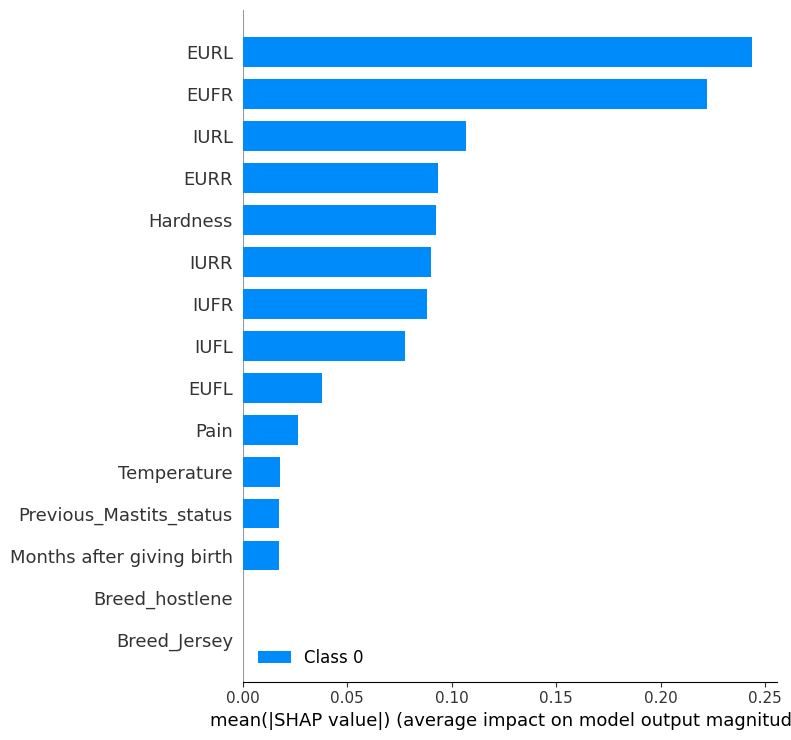

In [38]:
shap.summary_plot(
    shap_values,
    X_test_flat[:100],  # Use the features corresponding to the SHAP values
    feature_names=X_test.columns.tolist()[:15]  # Ensure the feature names list is correctly aligned
)

In [39]:
top_5_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 828 to 1222
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Months after giving birth  5 non-null      int64  
 1   Previous_Mastits_status    5 non-null      int64  
 2   IUFL                       5 non-null      int64  
 3   EUFL                       5 non-null      int64  
 4   IUFR                       5 non-null      int64  
 5   EUFR                       5 non-null      int64  
 6   IURL                       5 non-null      int64  
 7   EURL                       5 non-null      int64  
 8   IURR                       5 non-null      int64  
 9   EURR                       5 non-null      int64  
 10  Temperature                5 non-null      int64  
 11  Hardness                   5 non-null      int64  
 12  Pain                       5 non-null      int64  
 13  Breed_Jersey               5 non-null      int64  
 14

In [40]:
X_sample_test = top_5_predictions.drop(columns=[ 'Predicted Probability','Actual Label'])
X_sample_test

,Months after giving birth,Previous_Mastits_status,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature,Hardness,Pain,Breed_Jersey,Breed_hostlene
828,1,0,314,355,161,178,157,174,160,183,47,1,1,1,0
199,1,0,307,358,159,183,157,186,152,191,44,1,1,1,0
921,3,0,312,372,158,191,159,182,160,182,52,1,1,1,0
180,3,0,156,180,304,360,154,174,160,177,45,1,1,1,0
1222,2,0,312,362,151,181,151,182,152,181,52,1,1,1,0


In [41]:
Y_sample_test = top_5_predictions['Actual Label'].values
Y_sample_test

array([1, 1, 1, 1, 1])

In [42]:
X_test_flat[:20]
shap_values

[array([[ 0.        ,  0.        ,  0.        , -0.09439103, -0.01639927,
          0.04379129, -0.06286214,  0.07135005, -0.06134512, -0.11670691,
          0.        , -0.09073133,  0.        ,  0.        ,  0.        ],
        [ 0.02988964,  0.        ,  0.01668235, -0.02291224, -0.15301873,
          0.58987634,  0.01416581,  0.05818553,  0.        , -0.05350726,
          0.02708421,  0.1404954 , -0.04567117,  0.        ,  0.        ],
        [ 0.        ,  0.        , -0.16619353, -0.04341895,  0.206343  ,
         -0.32558709,  0.19523289, -0.3258127 ,  0.17442584,  0.1308966 ,
          0.        , -0.09784805,  0.        ,  0.        ,  0.        ],
        [-0.00421767, -0.02755036,  0.02658008,  0.        , -0.01603512,
          0.09079783, -0.18952975,  0.63839199,  0.        , -0.02727316,
         -0.03542204,  0.1456232 ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        , -0.19421154, -0.06939853,  0.14659457,
         -0.32214831,  0.20968144,

In [43]:
X_sample_test_flat = X_sample_test.values
X_sample_test_flat

array([[  1,   0, 314, 355, 161, 178, 157, 174, 160, 183,  47,   1,   1,
          1,   0],
       [  1,   0, 307, 358, 159, 183, 157, 186, 152, 191,  44,   1,   1,
          1,   0],
       [  3,   0, 312, 372, 158, 191, 159, 182, 160, 182,  52,   1,   1,
          1,   0],
       [  3,   0, 156, 180, 304, 360, 154, 174, 160, 177,  45,   1,   1,
          1,   0],
       [  2,   0, 312, 362, 151, 181, 151, 182, 152, 181,  52,   1,   1,
          1,   0]])

In [44]:
shap_values_v1 = explainer.shap_values(X_sample_test_flat, nsamples=100)

  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [45]:
shap_values_v1

[array([[-0.02679717,  0.        ,  0.25655379,  0.10274784,  0.09926765,
         -0.14204317,  0.1367825 , -0.2075204 ,  0.10049373,  0.1483921 ,
         -0.03842441,  0.13177377,  0.05268346,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.19906688,  0.09504306,  0.10905672,
         -0.14517678,  0.09046568, -0.1911329 ,  0.12466   ,  0.1566565 ,
          0.        ,  0.1368069 ,  0.03846359,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.27527061,  0.0668341 ,  0.05593862,
         -0.08129546,  0.12338895, -0.16924312,  0.0572273 ,  0.09272423,
          0.        ,  0.16193802,  0.03112639,  0.        ,  0.        ],
        [-0.02243897,  0.04120727, -0.07807815, -0.0420956 , -0.04083146,
          0.42250556,  0.14021082, -0.21198536,  0.12376825,  0.13370824,
          0.01053855,  0.13733825,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.22138233,  0.07251722,  0.11500206,
         -0.14503808,  0.1472742 ,

In [46]:
shap.initjs()
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][0],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [47]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][0],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_0.html', shap_html)

In [48]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][1],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [49]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][1],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_1.html', shap_html)

In [50]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][2],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [51]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][2],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_2.html', shap_html)

In [52]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][3],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [53]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][3],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_3.html', shap_html)

In [54]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][4],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [55]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][4],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_4.html', shap_html)

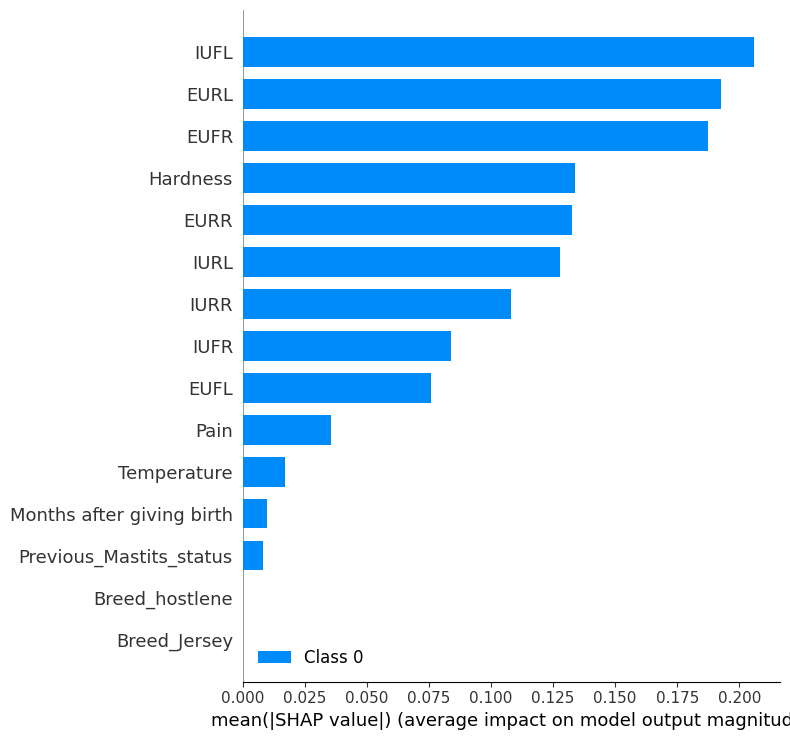

In [56]:
shap.summary_plot(
    shap_values_v1,
    X_sample_test_flat,  # Use the features corresponding to the SHAP values
    feature_names=X_test.columns.tolist()[:15], # Ensure the feature names list is correctly aligned
)

In [57]:
shap.plots.force(explainer.expected_value,shap_values[0],feature_names=X_test.columns.tolist())

In [58]:
shap_html = shap.plots.force(explainer.expected_value,shap_values[0],feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/General_force_plot.html', shap_html)

In [59]:
shap.plots.force(explainer.expected_value,shap_values_v1[0],feature_names=X_test.columns.tolist())

In [60]:
  shap_html = shap.force_plot(
    explainer.expected_value,shap_values_v1[0],feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/top_5_predictions_force_plot_1.html', shap_html)

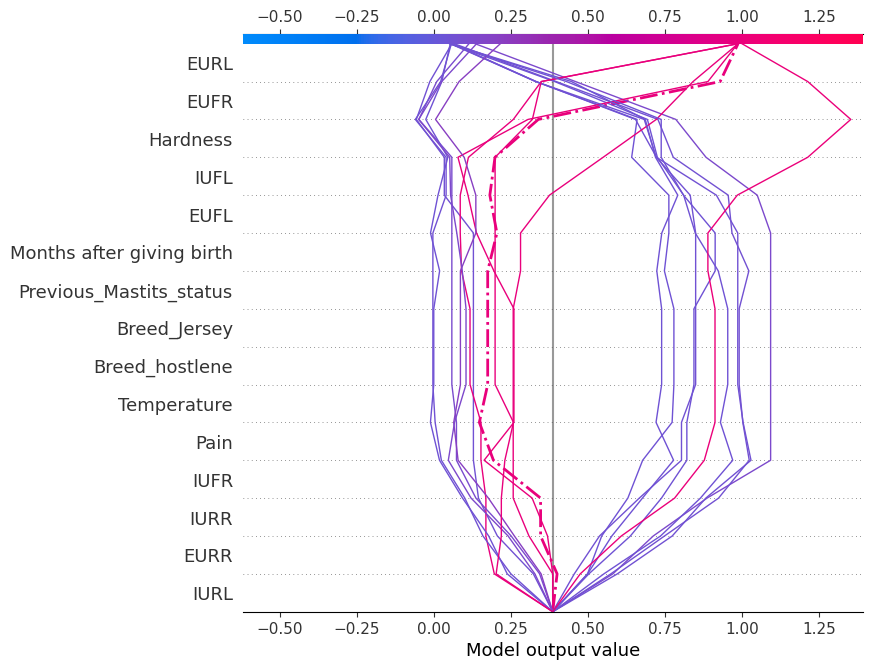

In [61]:
shap.decision_plot(explainer.expected_value, shap_values[0], feature_names=X_test.columns.tolist(),link="identity", highlight=1,legend_location="best",
                  feature_order="hclust")

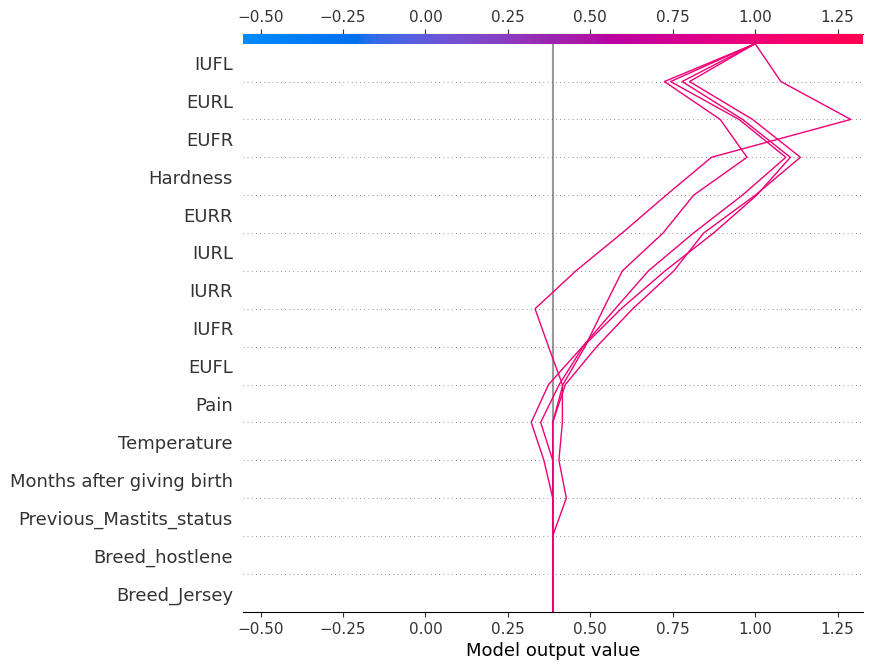

In [62]:
shap.decision_plot(explainer.expected_value, shap_values_v1[0], feature_names=X_test.columns.tolist(),)

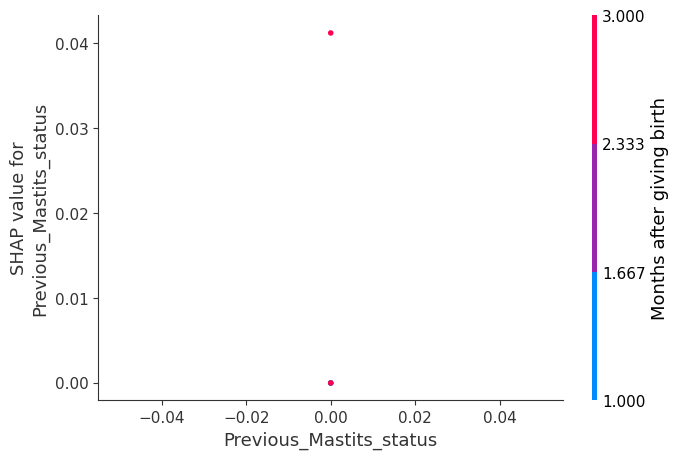

In [63]:
shap.dependence_plot(1, shap_values_v1[0], X_sample_test_flat,feature_names=X_test.columns.tolist())

In [64]:
# Flatten the SHAP values to match the expected shape (samples, features)
shap_values_flat = np.array(shap_values_v1).reshape((5, 15))
shap_values_flat


array([[-0.02679717,  0.        ,  0.25655379,  0.10274784,  0.09926765,
        -0.14204317,  0.1367825 , -0.2075204 ,  0.10049373,  0.1483921 ,
        -0.03842441,  0.13177377,  0.05268346,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.19906688,  0.09504306,  0.10905672,
        -0.14517678,  0.09046568, -0.1911329 ,  0.12466   ,  0.1566565 ,
         0.        ,  0.1368069 ,  0.03846359,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.27527061,  0.0668341 ,  0.05593862,
        -0.08129546,  0.12338895, -0.16924312,  0.0572273 ,  0.09272423,
         0.        ,  0.16193802,  0.03112639,  0.        ,  0.        ],
       [-0.02243897,  0.04120727, -0.07807815, -0.0420956 , -0.04083146,
         0.42250556,  0.14021082, -0.21198536,  0.12376825,  0.13370824,
         0.01053855,  0.13733825,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.22138233,  0.07251722,  0.11500206,
        -0.14503808,  0.1472742 , -0.18300487, 

In [65]:
import shap
shap_values_expl = shap.Explanation(values=shap_values_flat, base_values=explainer.expected_value, data=X_test_flat, feature_names=X_test.columns.tolist())


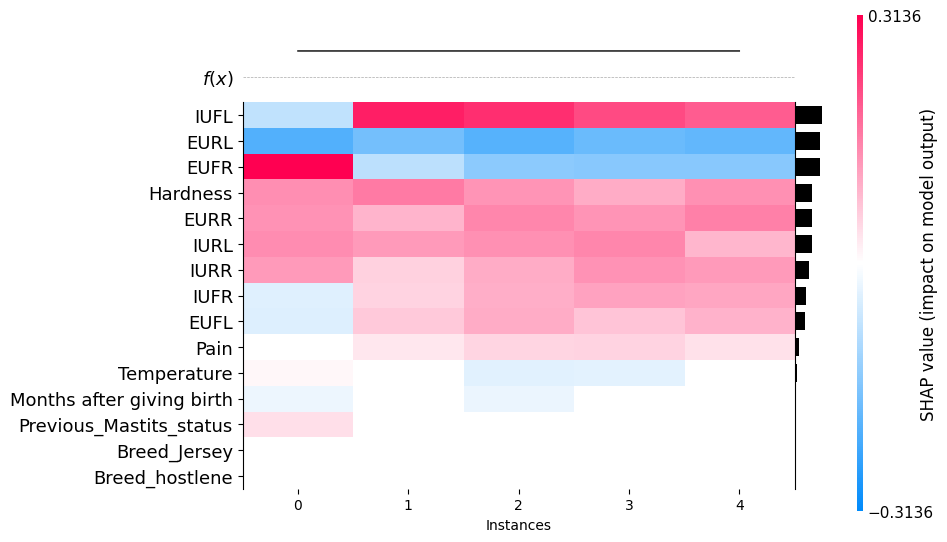

In [66]:
# Visualize SHAP values using heatmap
shap.plots.heatmap(shap_values_expl, max_display=15)

In [67]:
# Flatten the SHAP values to match the expected shape (samples, features)
shap_values_flat_1 = np.array(shap_values).reshape((20, 15))
shap_values_flat_1
shap_values_expl_1 = shap.Explanation(values=shap_values_flat_1, base_values=explainer.expected_value, data=X_test_flat[:20], feature_names=X_test.columns.tolist())


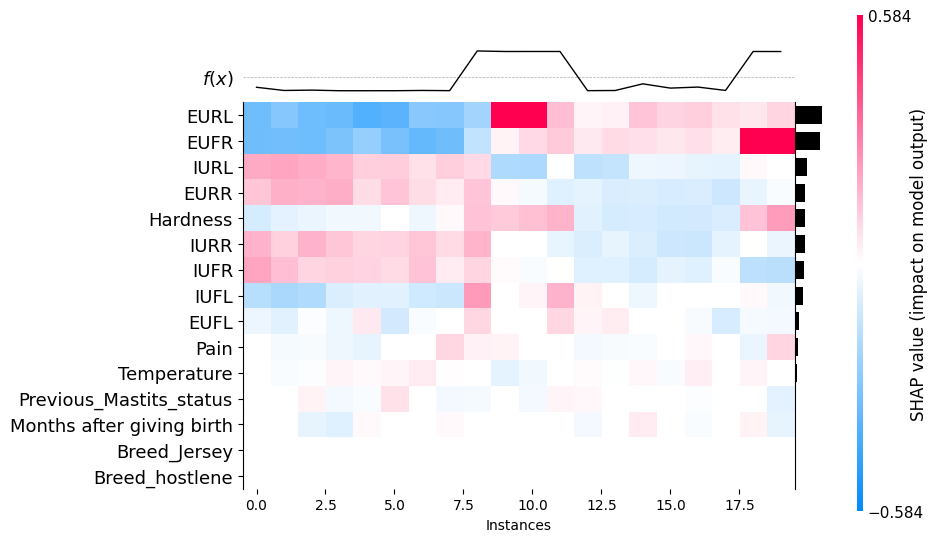

In [68]:
shap.plots.heatmap(shap_values_expl_1, max_display=15)